In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.utils.rnn as rnn_utils

import torch.nn as nn
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os
import gc
import csv

import json
from tqdm import tqdm
import pickle
import random

import math

import seaborn as sn
from IPython.display import clear_output
from ipywidgets import Output
from IPython import display
import pickle
from scipy.spatial.distance import cdist 
from scipy import spatial

In [2]:
#device = torch.cuda.device(2)
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [3]:
seed_value = 17
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
random.seed(17)

In [4]:
target_players = ['Anders ANTONSEN',
 'Anthony Sinisuka GINTING',
 'CHEN Long',
 
 'CHOU Tien Chen',
 'Jonatan CHRISTIE',
 'Kento MOMOTA',
 'Khosit PHETPRADAB',
 'NG Ka Long Angus',
 
 'SHI Yuqi',
 
 'Viktor AXELSEN',
 'WANG Tzu Wei']

In [5]:
def player2cat(player):
    p2c = {'Anders ANTONSEN': 0, 'Anthony Sinisuka GINTING': 1, 'CHEN Long': 2,
      'CHOU Tien Chen': 3, 'Jonatan CHRISTIE': 4, 'Kento MOMOTA': 5,
     'Khosit PHETPRADAB': 6, 'NG Ka Long Angus': 7,
     'SHI Yuqi': 8,  'Viktor AXELSEN': 9, 'WANG Tzu Wei': 10}
    return p2c[player]

def cat2player(cat):
    c2p = {0:'ANTONSEN', 1:'GINTING', 2:'Long',  3:'CHOU', 4:'CHRISTIE',
           5:'MOMOTA', 6:'PHETPRADAB', 7:'NG',  8:'SHI', 
           9:'AXELSEN', 10:'WANG'}
    return c2p[cat]

def generate_labels(rally_data):
    # predict player A and B
    playerA = rally_data['name_A'].values[0]
    playerB = rally_data['name_B'].values[0]

    if playerA in target_players and playerB in target_players:
        return np.array([player2cat(playerA)]),  np.array([player2cat(playerB)])
    elif playerA not in target_players and playerB in target_players:
        return None,  np.array([player2cat(playerB)])
    elif playerA in target_players and playerB not in target_players:
        return np.array([player2cat(playerA)]),  None
    elif playerA in target_players and playerB in target_players:
        return None,  None

In [6]:
def generate_rally_ids(rally_data):
    # predict player A and B
    playerA = rally_data['name_A'].values[0]
    playerB = rally_data['name_B'].values[0]
    rally_id = rally_data['rally_id'].values[0]
    
    if playerA in target_players and playerB in target_players:
        return np.array([rally_id]),  np.array([rally_id])
    elif playerA not in target_players and playerB in target_players:
        return None,  np.array([rally_id])
    elif playerA in target_players and playerB not in target_players:
        return np.array([rally_id]),  None
    elif playerA in target_players and playerB in target_players:
        return None,  None

In [7]:
def generate_opponent_name(rally_data):
    # predict player A and B
    playerA = rally_data['name_A'].values[0]
    playerB = rally_data['name_B'].values[0]

    if playerA in target_players and playerB in target_players:
        return np.array([playerB]),  np.array([playerA])
    elif playerA not in target_players and playerB in target_players:
        return None,  np.array([playerA])
    elif playerA in target_players and playerB not in target_players:
        return np.array([playerB]),  None
    elif playerA in target_players and playerB in target_players:
        return None,  None

In [8]:
def type2cat(shot_type):
    t2c = {'發短球': 0, '長球': 1, '推撲球': 2, '殺球': 3, '接殺防守': 4, '平球': 5,
           '網前球': 6, '挑球': 7, '切球': 8, '發長球': 9}
    return t2c[shot_type]

def process_rally(rally_data):
    mean_x, std_x = 630., 160.
    mean_y, std_y = 470., 105.
    
    drop_cols = ['rally', 'rally_id', 'match_id', 'set', 'ball_round', 'time', 'frame_num', 'db', 'flaw', 'lose_reason', 'win_reason', 'type', 'server',
                 'hit_area', 'landing_area', 'player_location_area', 'opponent_location_area',
                 'name_A', 'name_B', 'getpoint_player', 'roundscore_A', 'roundscore_B',
                 'landing_height', 'landing_x', 'landing_y']
    
    playerA = rally_data['name_A'].values[0]
    playerB = rally_data['name_B'].values[0]    
    
    frame_diff = np.pad(rally_data['frame_num'].values[1:] - rally_data['frame_num'].values[:-1], (1, 0), mode='constant')
    rally_data['frame_diff'] = frame_diff
    
    rally_data['aroundhead'] = (rally_data['aroundhead'] == 1).astype(int)
    rally_data['backhand'] = (rally_data['backhand'] == 1).astype(int)

    rally_data['player'] = (rally_data['player'] == 'A').astype(int)
    
    rally_data['hit_height'] = (rally_data['hit_height'] -1)
    rally_data['landing_height'] = (rally_data['landing_height'] -1)
    
    rally_data['hit_x'].values[0] = rally_data['player_location_x'].values[0]
    rally_data['hit_y'].values[0] = rally_data['player_location_y'].values[0]
    
    rally_data['hit_x'] = (rally_data['hit_x'] - mean_x)/std_x
    rally_data['hit_y'] = (rally_data['hit_y'] - mean_y)/std_y
    rally_data['landing_x'] = (rally_data['landing_x'] - mean_x)/std_x
    rally_data['landing_y'] = (rally_data['landing_y'] - mean_y)/std_y
    rally_data['player_location_x'] = (rally_data['player_location_x'] - mean_x)/std_x
    rally_data['player_location_y'] = (rally_data['player_location_y'] - mean_y)/std_y
    rally_data['opponent_location_x'] = (rally_data['opponent_location_x'] - mean_x)/std_x
    rally_data['opponent_location_y'] = (rally_data['opponent_location_y'] - mean_y)/std_y

    rally_data['type_code'] = [type2cat(t) for t in rally_data['type'].values]
    rally_data.drop(columns=drop_cols, inplace=True)
    
    inverse = rally_data.copy()
    inverse['player'] = (inverse['player']+1)%2
    
    if playerA in target_players and playerB in target_players:
        return rally_data.values, inverse.values
    elif playerA not in target_players and playerB in target_players:
        return None, inverse.values
    elif playerA in target_players and playerB not in target_players:
        return rally_data.values, None
    elif playerA in target_players and playerB in target_players:
        return None,  None


In [9]:
def collate_fn(data):
    seq, label, rally_id, opponent_name = zip(*data)
    seq = list(seq)
    label = list(label)
    rally_id = list(rally_id)
    opponent_name = list(opponent_name)
    pairs = [(s, l, r, o) for s, l, r, o in zip(seq, label, rally_id, opponent_name)]
    pairs.sort(key=lambda x: len(x[0]), reverse=True)
    seq = [s for s, l, r, o in pairs]
    label = [l for s, l, r, o in pairs]
    rally_id  = [r for s, l, r, o in pairs]
    opponent_name  = [o for s, l, r, o in pairs]
    seq_length = [len(sq) for sq in seq]
    seq = rnn_utils.pad_sequence(seq, batch_first=True, padding_value=0)
    labels = torch.zeros(0, 1)
    for l in label:
        labels = torch.cat([labels, l], axis=0)
    return seq, seq_length, labels, rally_id, opponent_name

In [10]:
data_path = 'aug_set.csv'

In [11]:
def check_nan(np_rally):
    if np_rally is None:
        return False
    else:
        return np.isnan(np.sum(np_rally))

In [12]:
data = pd.read_csv(data_path)

rids = set()
# drop flawed rallies, record label distribution
for rally in tqdm(data['rally_id'].unique()):
    if data.loc[data['rally_id']==rally]['flaw'].any() or len(data.loc[data['rally_id']==rally])<=2 or rally in [578, 596]:
        continue
    else:
        rids.add(rally)

100%|██████████| 2575/2575 [00:02<00:00, 1214.74it/s]


In [13]:
def train_test_split(label2rids, test_ratio):
    test = random.sample(label2rids, k=round(len(label2rids)*test_ratio))
    train = [rid for rid in label2rids if rid not in test]
    return train, test

In [14]:
class PlayerClassificationDataset(Dataset):
    def __init__(self, data, rids, split):
        self.data = data
        self.rids = rids
        self.seqs = []
        self.labels = []
        self.rally_ids = []        
        self.opponent_names = []
        
        tmp = [process_rally(self.data.loc[self.data['rally_id']==rally].copy()) for rally in rids]
        for seq1, seq2 in tmp:
            if seq1 is not None:
                self.seqs.append(seq1)
            if seq2 is not None:
                self.seqs.append(seq2)

        tmp = [generate_labels(self.data.loc[self.data['rally_id']==rally].copy()) for rally in rids]
        for label1, label2 in tmp:
            if label1 is not None:
                self.labels.append(label1)
            if label2 is not None:
                self.labels.append(label2)    
                
        tmp = [generate_rally_ids(self.data.loc[self.data['rally_id']==rally].copy()) for rally in rids]
        for rally_id1, rally_id2 in tmp:
            if rally_id1 is not None:
                self.rally_ids.append(rally_id1)
            if rally_id2 is not None:
                self.rally_ids.append(rally_id2)
                
        tmp = [generate_opponent_name(self.data.loc[self.data['rally_id']==rally].copy()) for rally in rids]
        for opponent_name1, opponent_name2 in tmp:
            if opponent_name1 is not None:
                self.opponent_names.append(opponent_name1)
            if opponent_name2 is not None:
                self.opponent_names.append(opponent_name2)

        self.nan_checking()
    def __len__(self):
        return len(self.seqs)
    
    def __getitem__(self, index):
        return torch.Tensor(self.seqs[index]), torch.Tensor(self.labels[index]).unsqueeze(0), torch.Tensor(self.rally_ids[index]).unsqueeze(0), self.opponent_names[index]
    
    def nan_checking(self):
        bad_idxs = [idx for idx in range(len(self.seqs)) if check_nan(self.seqs[idx])]
        self.seqs = [seq for idx, seq in enumerate(self.seqs) if idx not in bad_idxs]
        self.labels = [label for idx, label in enumerate(self.labels) if idx not in bad_idxs]
        self.rally_ids = [label for idx, label in enumerate(self.rally_ids) if idx not in bad_idxs]
        self.opponent_names = [label for idx, label in enumerate(self.opponent_names) if idx not in bad_idxs]
#         print("Removed %d rallies with NaN value!"%len(bad_idxs))

In [15]:
class CNNRNN(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, out_dim, GRU_layers):
        super(CNNRNN, self).__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.GRU_layers = GRU_layers
        
        self.type_embedding = nn.Embedding(10, self.embed_dim)
        self.proj = nn.Linear(self.input_dim - 1, self.hidden_dim - self.embed_dim)
        self.fc1 = nn.Linear(self.hidden_dim, self.hidden_dim)
        
        self.conv1 = nn.Conv1d(self.hidden_dim, self.hidden_dim, kernel_size=3, stride=1, padding=1)
        self.GRU = nn.GRU(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers=self.GRU_layers, bias=True, batch_first=True, bidirectional=True)
        self.fc2 = nn.Linear(self.hidden_dim*2, self.hidden_dim)
        self.output = nn.Linear(self.hidden_dim, self.out_dim)
        self.relu = nn.ReLU()
        
    def forward(self, seq, seq_length):
        feats = seq[:, :, :-1]
        code = seq[:, :, -1].long()
        embed = self.type_embedding(code)
        feats_proj = self.proj(feats)
        x = torch.cat([feats_proj, embed], axis=-1)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        
        x = rnn_utils.pack_padded_sequence(x, seq_length, batch_first=True, enforce_sorted=False)
        output, h_n = self.GRU(x)

        out_pad, out_len = rnn_utils.pad_packed_sequence(output, batch_first=True)
        x = out_pad[torch.arange(out_len.shape[0]), out_len-1, :]
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        y = self.output(x)
        return x, y

In [16]:
def generate_all_embedding(num_classes, hidden_dim, model, pc_loader):
    with torch.no_grad():
        model.eval()
        embeddings = torch.zeros(0, hidden_dim).cuda()
        classes = torch.zeros(0).long().cuda()
        rally_ids = []
        opponent_names = []
        for seq, seq_length, labels, rally_id, opponent_name in pc_loader:
            seq = seq.cuda()
            rally_ids.append(int(rally_id[0][0].item()))
            opponent_names.append(opponent_name[0][0])
            labels = labels.squeeze(1).long().cuda()
            output,_ = model(seq, seq_length)

            embeddings = torch.cat([embeddings, output], axis=0)
            classes = torch.cat([classes, labels], axis=0)
            
    return embeddings, classes.cpu().numpy(), rally_ids, opponent_names

In [17]:
train, test = train_test_split(rids, 0.2)
train_dataset = PlayerClassificationDataset(data, train, 'train')
test_dataset = PlayerClassificationDataset(data, test, 'test')

In [18]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [19]:
num_classes = 11
hidden_dim = 64

In [20]:
with open('./5_29_player_embedding_no_girl', 'rb') as handle:
    class_embedding = pickle.load(handle)

In [21]:
class_embedding = np.array(list(class_embedding.values()))

In [22]:
def class_distance_viz(class_embedding):
    class_dist = cdist(class_embedding, class_embedding)
    fig, ax = plt.subplots(figsize=(12, 10))
    df = pd.DataFrame(class_dist, [cat2player(i) for i in range(num_classes)], [cat2player(i) for i in range(num_classes)])
    
    sn.heatmap(df, annot=True, annot_kws={"size": 10}, cmap='GnBu', fmt='.2f', ax=ax, square=True)
    b, t = ax.get_ylim()
    b += 0.5 
    t -= 0.5 
    ax.set_title("Distance of Embedding between Players")
    ax.set_ylim(b, t) 
    ax.xaxis.set_tick_params(rotation=90)
    ax.yaxis.set_tick_params(rotation=0)
    ax.set_xlabel('Player')
    ax.set_ylabel('Player')
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    ax.title.set_fontsize(16)

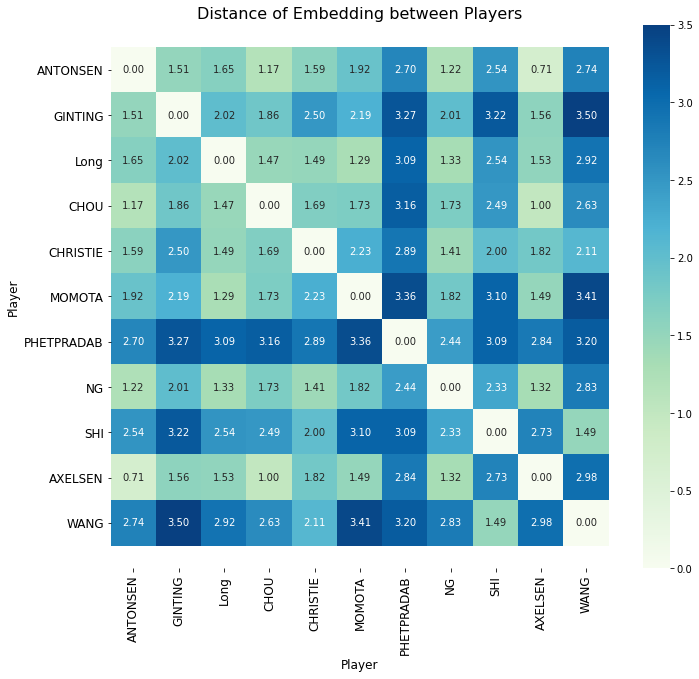

In [23]:
class_distance_viz(class_embedding)

In [24]:
net = CNNRNN(12, 32, hidden_dim, num_classes, 2).cuda()
net.load_state_dict(torch.load('for_5_29_no_girl.pt'))
net.eval()

CNNRNN(
  (type_embedding): Embedding(10, 32)
  (proj): Linear(in_features=11, out_features=32, bias=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (GRU): GRU(64, 64, num_layers=2, batch_first=True, bidirectional=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=11, bias=True)
  (relu): ReLU()
)

In [25]:
train_embedding, train_label, train_id, train_opponent_name = generate_all_embedding(num_classes, hidden_dim, net, train_loader)
test_embedding, test_label, test_id, test_opponent_name = generate_all_embedding(num_classes, hidden_dim, net, test_loader)

In [26]:
train_embedding = train_embedding.cpu().numpy()
test_embedding = test_embedding.cpu().numpy()

In [27]:
all_embedding = np.concatenate([train_embedding, test_embedding])
all_label = np.concatenate([train_label, test_label])
all_id = np.concatenate([train_id, test_id])
all_opponent_name = np.concatenate([train_opponent_name, test_opponent_name])

In [28]:
all_embedding.shape, all_label.shape, all_id.shape, all_opponent_name.shape

((4797, 64), (4797,), (4797,), (4797,))

In [29]:
all_dist = cdist(all_embedding, class_embedding)

In [30]:
all_pred = np.argmin(all_dist, axis=1)

In [31]:
all_wrong_dict = {0 : [], 1 : [], 2 : [], 3 : [],
              4 : [], 5 : [], 6 : [], 7 : [], 8 : [], 9 : [], 10 : []}

In [32]:
for i in range(len(all_dist)):
    if all_pred[i] != all_label[i]:
        all_wrong_dict[all_label[i]].append([all_id[i], all_pred[i], all_opponent_name[i]])

In [33]:
class_dist = cdist(class_embedding, class_embedding)

In [34]:
most_likely = np.argsort(class_dist, axis=1)[:, -2]
most_unlikely = np.argmax(class_dist, axis=1)

In [35]:
for i in range(num_classes):
    print('Target: ', target_players[i])
    print('Like: ', target_players[most_likely[i]])
    print('Unlike:', target_players[most_unlikely[i]])
    print()

Target:  Anders ANTONSEN
Like:  Khosit PHETPRADAB
Unlike: WANG Tzu Wei

Target:  Anthony Sinisuka GINTING
Like:  Khosit PHETPRADAB
Unlike: WANG Tzu Wei

Target:  CHEN Long
Like:  WANG Tzu Wei
Unlike: Khosit PHETPRADAB

Target:  CHOU Tien Chen
Like:  WANG Tzu Wei
Unlike: Khosit PHETPRADAB

Target:  Jonatan CHRISTIE
Like:  Anthony Sinisuka GINTING
Unlike: Khosit PHETPRADAB

Target:  Kento MOMOTA
Like:  Khosit PHETPRADAB
Unlike: WANG Tzu Wei

Target:  Khosit PHETPRADAB
Like:  Anthony Sinisuka GINTING
Unlike: Kento MOMOTA

Target:  NG Ka Long Angus
Like:  Khosit PHETPRADAB
Unlike: WANG Tzu Wei

Target:  SHI Yuqi
Like:  Kento MOMOTA
Unlike: Anthony Sinisuka GINTING

Target:  Viktor AXELSEN
Like:  Khosit PHETPRADAB
Unlike: WANG Tzu Wei

Target:  WANG Tzu Wei
Like:  Kento MOMOTA
Unlike: Anthony Sinisuka GINTING



In [36]:
"""
'Anders ANTONSEN': 0, 
'Anthony Sinisuka GINTING': 1, 
'CHEN Long': 2,
'CHOU Tien Chen': 3, 
'Jonatan CHRISTIE': 4, 
'Kento MOMOTA': 5,
'Khosit PHETPRADAB': 6, 
'NG Ka Long Angus': 7,
'SHI Yuqi': 8,  
'Viktor AXELSEN': 9, 
'WANG Tzu Wei': 10
"""

"\n'Anders ANTONSEN': 0, \n'Anthony Sinisuka GINTING': 1, \n'CHEN Long': 2,\n'CHOU Tien Chen': 3, \n'Jonatan CHRISTIE': 4, \n'Kento MOMOTA': 5,\n'Khosit PHETPRADAB': 6, \n'NG Ka Long Angus': 7,\n'SHI Yuqi': 8,  \n'Viktor AXELSEN': 9, \n'WANG Tzu Wei': 10\n"

In [37]:
player = 10

In [38]:
from collections import Counter
count = Counter()
for i in range(len(all_dist)):
    if all_label[i] == player:
        count[all_opponent_name[i]] += 1
count

Counter({'Kento MOMOTA': 64, 'Khosit PHETPRADAB': 103})

In [39]:
from collections import Counter
count = Counter()
for name in all_wrong_dict[player]:
    count[name[2]] += 1
count

Counter({'Kento MOMOTA': 4})

In [40]:
from collections import Counter
count = Counter()
for name in all_wrong_dict[player]:
    count[cat2player(name[1])] += 1
count

Counter({'ANTONSEN': 1, 'CHOU': 2, 'Long': 1})

In [41]:
from collections import Counter, defaultdict
ht = {}
count = defaultdict(lambda: defaultdict(lambda: 0))
for name in all_wrong_dict[player]:
    count[name[2]][cat2player(name[1])] += 1
count

defaultdict(<function __main__.<lambda>()>,
            {'Kento MOMOTA': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'ANTONSEN': 1, 'CHOU': 2, 'Long': 1})})